In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_regression
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%config InlineBakend.figure_format = 'svg'
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from catboost import Pool, CatBoostRegressor
from catboost import CatBoostClassifier
from catboost import FeaturesData
import catboost
pd.set_option('display.max_columns', 500)
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
pd.options.display.float_format = '{:.2f}'.format


In [2]:
def get_report(y_true, y_pred):
    return print(classification_report(y_true, y_pred))


In [3]:
def get_NaN(df):
    nan_cols = [i for i in df.columns if df[i].isnull().any()]
    print('NaN     Sum')
    lst = []
    for i in nan_cols:
        lst.append(f'{i} = {df[i].isnull().sum()}')
    return print('\n'.join(lst))

In [4]:
data = pd.read_csv("course_project_train.csv")


In [5]:
data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,5943.00,7500.00
mean,1366391.72,0.03,11.13,18.32,945153.73,0.17,34.69,0.12,11873177.45,289833.24,18314.45,1151.09,0.28
std,845339.20,0.27,4.91,7.04,16026216.67,0.50,21.69,0.35,31926122.97,317871.38,11926.76,1604.45,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00,0.00
25%,844341.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,180169.00,114256.50,10067.50,711.00,0.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00,0.00
75%,1640137.00,0.00,14.00,21.80,793501.50,0.00,50.00,0.00,519882.00,360406.25,23818.00,743.00,1.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00,1.00


### Введем dummies для категориальных features

In [6]:
dm_purpose = pd.get_dummies(data['Purpose']+' (Purpose)')
dm_ownership = pd.get_dummies(data['Home Ownership'] + ' (Ownership)') 
dm_term = pd.get_dummies(data['Term']+' (Term)')

In [7]:
df = pd.concat([data, dm_purpose, dm_ownership, dm_term], axis=1).drop(['Purpose', 'Home Ownership', 'Term'], axis=1)


### Поработаем с выбросами данных

<AxesSubplot:xlabel='Annual Income'>

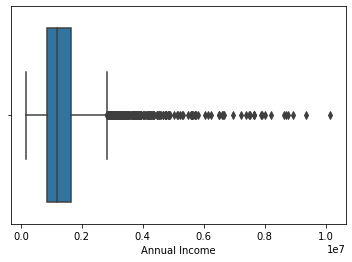

In [8]:
sns.boxplot(x=df['Annual Income'])

In [9]:
df.loc[df['Annual Income'] > 3500000,'Annual Income'] = df['Annual Income'].mean()


In [10]:
df.loc[df['Maximum Open Credit'] > 3500000,'Maximum Open Credit'] = df['Maximum Open Credit'].mean()
    

In [11]:
df['Current Loan Amount'].loc[(df['Current Loan Amount']==99999999)] = 309573

C:\Users\1\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [12]:
df.loc[df['Credit Score'] > 800,'Credit Score'] = df['Credit Score'].mean()


### Уберем NaN

In [13]:
get_NaN(df)

NaN     Sum
Annual Income = 1557
Years in current job = 371
Months since last delinquent = 4081
Bankruptcies = 14
Credit Score = 1557


In [14]:
df['Years in current job'].loc[(df['Years in current job'] == '< 1 year')] = 0

C:\Users\1\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [15]:
df['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', 0, '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [16]:
df['Years in current job']  = df['Years in current job'].astype(str).str.extract('(\d{1,})').fillna(-1).astype(int)


In [17]:
df.loc[df['Years in current job'] == -1,'Years in current job'] = df['Years in current job'].mean()


In [18]:
df['Bankruptcies'] = df['Bankruptcies'].fillna(0.00)


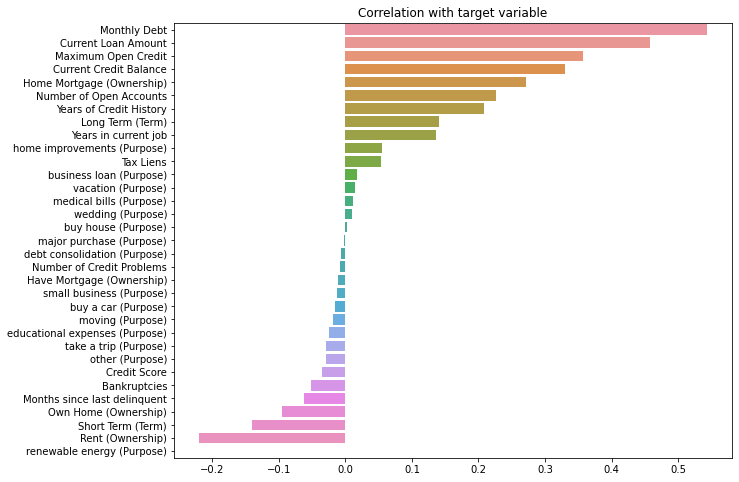

In [19]:
names = ['Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score',
       'business loan (Purpose)', 'buy a car (Purpose)',
       'buy house (Purpose)', 'debt consolidation (Purpose)',
       'educational expenses (Purpose)', 'home improvements (Purpose)',
       'major purchase (Purpose)', 'medical bills (Purpose)',
       'moving (Purpose)', 'other (Purpose)', 'renewable energy (Purpose)',
       'small business (Purpose)', 'take a trip (Purpose)',
       'vacation (Purpose)', 'wedding (Purpose)', 'Have Mortgage (Ownership)',
       'Home Mortgage (Ownership)', 'Own Home (Ownership)', 'Rent (Ownership)',
       'Long Term (Term)', 'Short Term (Term)', 'Months since last delinquent' ]
corr_with_target_AI = df[names + ['Annual Income']].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target_AI.values, y=corr_with_target_AI.index)

plt.title('Correlation with target variable')
plt.show()

######  Обучим моедль для поиска значения Annual Income

In [20]:
names_ai = ['Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit','Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score']
df_ai = df[names_ai].loc[(df['Annual Income'].dropna().index)]
target_ai = df['Annual Income'].loc[(df['Annual Income'].notna())]

X_train_ai, X_test_ai, y_train_ai, y_test_ai = train_test_split(df_ai, target_ai, test_size  = 0.25, random_state = 42)


In [21]:
catreg_ai= CatBoostRegressor(verbose=False,n_estimators=1000, nan_mode='Min', od_type='Iter').fit(X_train_ai, y_train_ai)
catreg_ai_pred = catreg_ai.predict(X_test_ai)

print(f'R^2 score = {r2_score(y_test_ai, catreg_ai_pred):.4f}')

R^2 score = 0.4528


In [22]:
ai_NaN = df.loc[df['Annual Income'].isna()]
ai_NaN_data = ai_NaN.drop(['Annual Income'], axis=1)
ai_NaN_predict = catreg_ai.predict(ai_NaN_data)

In [23]:
df.loc[df['Annual Income'].isna(), ['Annual Income']] = ai_NaN_predict


In [24]:
### Т.к. число строк с NaN Months since last delinquent более 50%, сделаем предположим, что NaN = 0
df.loc[df['Months since last delinquent'].isna(), ['Months since last delinquent']] = 0

In [25]:
### Сдеаем предположение, что в случае default кредитный рейтинг должен должен упасть - поэтому заместим такие  значения min
df['Credit Score'].loc[(df['Credit Default']==1)&(df['Credit Score'].isna())] = df['Credit Score'].min()

C:\Users\1\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [26]:
### Сдеаем предположение о том, влияние основных коррелирующих параметров на Credit Score 
df['Credit Score'].loc[((df['Long Term (Term)']==1)&(df['Short Term (Term)']==0)\
                       &(df['Current Loan Amount']>=519882.00)&(df['Credit Score'].isna()))] = 711.00

C:\Users\1\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [27]:
df['Credit Score'].loc[((df['Long Term (Term)']==0)&(df['Short Term (Term)']==1)\
                       &(df['Current Loan Amount']<=180169.00)&(df['Credit Score'].isna()))] = 743.00

C:\Users\1\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [28]:
### оставшиеся позиции присвоем значение средней 
df.loc[df['Credit Score'].isna(), ['Credit Score']] = df['Credit Score'].mean()

## Модель

#### Используем методику oversampling метода SMOTE

In [29]:
sm = SMOTE(random_state=42)

In [30]:
imp_feature = ['Credit Score', 'Current Loan Amount','Short Term (Term)', 'Home Mortgage (Ownership)','Rent (Ownership)',\
           'Long Term (Term)']

In [31]:
data_test = df[imp_feature]
target = df['Credit Default']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data_test, target, test_size=0.25, random_state = 42)

In [33]:
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [34]:
cat_res = CatBoostClassifier(verbose=False).fit(X_train_res,y_train_res)

In [35]:
pred_res = cat_res.predict(X_test)

In [36]:
get_report(y_test, pred_res)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1313
           1       0.73      0.56      0.64       562

    accuracy                           0.81      1875
   macro avg       0.78      0.74      0.75      1875
weighted avg       0.80      0.81      0.80      1875



# Предскажем цену для тестового датасета

In [37]:
dt = pd.read_csv('course_project_test.csv')
dt = pd.DataFrame(dt)

In [38]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [39]:
dm_purpose_dt = pd.get_dummies(dt['Purpose']+' (Purpose)')
dm_ownership_dt = pd.get_dummies(dt['Home Ownership'] + ' (Ownership)') 
dm_term_dt = pd.get_dummies(dt['Term']+' (Term)')

In [40]:
df_test = pd.concat([dt, dm_purpose_dt, dm_ownership_dt, dm_term_dt], axis=1).drop(['Purpose', 'Home Ownership', 'Term'], axis=1)


In [41]:
df_test.loc[df_test['Annual Income'] > 3500000,'Annual Income'] = df_test['Annual Income'].mean()
df_test.loc[df_test['Maximum Open Credit'] > 3500000,'Maximum Open Credit'] = df_test['Maximum Open Credit'].mean()
df_test['Current Loan Amount'].loc[(df_test['Current Loan Amount']==99999999)] = 309573
df_test.loc[df_test['Credit Score'] > 800,'Credit Score'] = df_test['Credit Score'].mean()


C:\Users\1\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Уберем NaN

In [42]:
get_NaN(df_test)

NaN     Sum
Annual Income = 513
Years in current job = 86
Months since last delinquent = 1358
Bankruptcies = 3
Credit Score = 513


In [43]:
df_test['Years in current job'].loc[(df_test['Years in current job'] == '< 1 year')] = 0

C:\Users\1\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [44]:
df_test['Years in current job']  = df_test['Years in current job'].astype(str).str.extract('(\d{1,})').fillna(-1).astype(int)
df_test.loc[df_test['Years in current job'] == -1,'Years in current job'] = df_test['Years in current job'].mean()


In [45]:
df_test['Bankruptcies'] = df_test['Bankruptcies'].fillna(0.00)


######  Обучим моедль для поиска значения Annual Income

In [46]:
names_ai = ['Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit','Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score']
df_ai_test = df_test[names_ai].loc[(df_test['Annual Income'].dropna().index)]
target_ai_test = df_test['Annual Income'].loc[(df_test['Annual Income'].notna())]

X_train_ai_test, X_test_ai_test, y_train_ai_test, y_test_ai_test = train_test_split(df_ai_test, target_ai_test, test_size  = 0.25, random_state = 42)

In [47]:
catreg_ai_test= CatBoostRegressor(verbose=False,n_estimators=1000, nan_mode='Min', od_type='Iter').fit(X_train_ai, y_train_ai)
catreg_ai_pred_test = catreg_ai_test.predict(X_test_ai_test)

print(f'R^2 score = {r2_score(y_test_ai_test, catreg_ai_pred_test):.4f}')

R^2 score = 0.3402


In [48]:
ai_NaN_test = df_test.loc[df_test['Annual Income'].isna()]
ai_NaN_data_test = ai_NaN_test.drop(['Annual Income'], axis=1)
ai_NaN_predict_test = catreg_ai_test.predict(ai_NaN_data_test)

In [49]:
df_test.loc[df_test['Annual Income'].isna(), ['Annual Income']] = ai_NaN_predict_test


In [50]:
### Т.к. число строк с NaN Months since last delinquent более 50%, сделаем предположим, что NaN = 0
df_test.loc[df_test['Months since last delinquent'].isna(), ['Months since last delinquent']] = 0

In [51]:
### Сдеаем предположение о том, влияние основных коррелирующих параметров на Credit Score 
df_test['Credit Score'].loc[((df_test['Long Term (Term)']==1)&(df_test['Short Term (Term)']==0)\
                       &(df_test['Current Loan Amount']>=519882.00)&(df_test['Credit Score'].isna()))] = 711.00

C:\Users\1\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [52]:
df_test['Credit Score'].loc[((df_test['Long Term (Term)']==0)&(df_test['Short Term (Term)']==1)\
                       &(df_test['Current Loan Amount']<=180169.00)&(df_test['Credit Score'].isna()))] = 743.00

C:\Users\1\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [53]:
### оставшиеся позиции присвоем значение средней 
df_test.loc[df_test['Credit Score'].isna(), ['Credit Score']] = df_test['Credit Score'].mean()

In [54]:
y_pred_test = pd.DataFrame(cat_res.predict(df_test[imp_feature]),\
                          index=df_test.index)

In [55]:
df_test['Credit Default'] = y_pred_test[0]

In [56]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   2500 non-null   float64
 1   Years in current job            2500 non-null   float64
 2   Tax Liens                       2500 non-null   float64
 3   Number of Open Accounts         2500 non-null   float64
 4   Years of Credit History         2500 non-null   float64
 5   Maximum Open Credit             2500 non-null   float64
 6   Number of Credit Problems       2500 non-null   float64
 7   Months since last delinquent    2500 non-null   float64
 8   Bankruptcies                    2500 non-null   float64
 9   Current Loan Amount             2500 non-null   float64
 10  Current Credit Balance          2500 non-null   float64
 11  Monthly Debt                    2500 non-null   float64
 12  Credit Score                    25

In [57]:
finita = df_test['Credit Default']

In [58]:
finita.to_csv(r'Credit Default_test.csv')